# Predicting Candidate Votes Before The 2023 Finnish Parliamentary Elections

This code was used to create the ex-ante forecast published before the 2023 Finnish Parliamentary Elections. The output is predicted vote share for each candidate.

In [1]:
import pandas as pd
import scipy as sp
import numpy as np
import sidetable as stb
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import sklearn.metrics as metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


# set float format to only show 2 digits
pd.set_option('display.float_format', lambda x: '%.2f' % x)

pd.options.mode.chained_assignment = None

# Reading data

The csv files will be made public once a publication has been published.

Altought this is the ex ante forecast, the candidates.csv already also includes the results of the elections. However, the results of the elections are not used as predictive features in any way here.

In [56]:
# Load data from the much faster CSV files
candidates = pd.read_csv('candidates.csv')
train = pd.read_csv('train.csv')
districts = pd.read_csv('districts_2023.csv')


display(candidates.head())
display(train.head())
display(districts.head())

,year,last_election,district_id,district,municipality,party_id,party_id_2,party,party_prefvote_lag,candidate_election_number,...,presidential_vote,party_leader,candidate,district_candidate_id.1,candidate_id,twitter_handle,twitter_followers,fb_likes,election_result,prefvote
0,2023,2019,2,UUS,23,2,13,PS,15.86,338,...,0,1,Purra Riikka,338-2,15882,https://twitter.com/ir_rkp,54743,19918,ELECTED,42594
1,2023,2019,7,PIR,1,1,1,SDP,22.10,16,...,0,1,Marin Sanna,16-7,12823,https://twitter.com/MarinSanna,653126,210908,ELECTED,35628
2,2023,2019,1,HEL,4,3,8,KOK,21.82,152,...,0,0,Valtonen Elina,152-1,18899,https://twitter.com/elinavaltonen,85398,30830,ELECTED,32562
3,2023,2019,1,HEL,23,2,11,PS,12.26,193,...,0,0,Halla-Aho Jussi,193-1,11037,https://twitter.com/Halla_aho,117918,11066,ELECTED,22081
4,2023,2019,8,KAA,4,3,8,KOK,18.05,77,...,0,0,Häkkänen Antti,77-8,13790,https://twitter.com/anttihakkanen,38439,10323,ELECTED,21378


,candidate,prefvote,party_prefvote_lag,prefvote_lag,age,sex,fb_likes,last_presidential_elections,last_municipal_votes,last_eu_votes,political_experience,campaign_budget_scale,district,party,twitter_followers
0,Tuomioja Erkki,11154,17.50,9970.00,68,0,1303.00,NaN,NaN,NaN,3,5.00,HEL,SDP,0
1,Väyrynen Paavo,6889,32.20,2992.00,68,0,4365.00,NaN,287.00,69360.00,6,4.00,LAP,KESK,4545
2,Kanerva Ilkka,9183,23.00,7820.00,67,0,1314.00,NaN,1638.00,NaN,5,5.00,VAR,KOK,0
3,Gustafsson Jukka,6792,21.60,6793.00,68,0,383.00,NaN,2246.00,NaN,5,4.00,PIR,SDP,0
4,Heikkilä Olli,120,0.00,163.00,44,0,NaN,NaN,NaN,NaN,1,1.00,HÄM,PIR,0


,dist_id,distabb,seats
0,1,HEL,23
1,2,UUS,37
2,3,VAR,17
3,4,SAT,8
4,5,AHV,1


# Data Preprocessing & Feature Engineering

This section transforms the raw `candidates` data into a clean dataset suitable for machine learning models. The process involves cleaning data, creating new features from existing ones, and ensuring all data is in a machine-readable format.

The key steps are:

1.  **Initial Cleaning and Flagging**:
    *   **Handling Missing Values**: We replace missing values (nulls) in columns like `fb_likes` and past vote counts with `0`. This is based on the assumption that a missing value means the true count was zero.
    *   **Creating Binary Flags**: We create several "yes/no" columns (e.g., `president_candidate`, `pyear_run`) that hold a `1` if a candidate has that experience and a `0` if they do not.
    *   **Encoding**: The `sex` column is converted into a standard binary `0`/`1` format.

2.  **Creating Composite Features**:
    *   **`political_experience` Score**: A new feature is created by summing up all the binary experience flags. This aggregates a candidate's history into a single, powerful score.
    *   **`campaign_budget_scale`**: The raw, continuous `election_budget` is grouped into a simpler categorical scale (from 1 to 7). This process, called "binning," helps the model focus on general budget *levels* rather than noisy, exact figures.

In [57]:
candidates["president_candidate"] = np.where(candidates['presidential_vote'] > 0, 1, 0)
candidates["eu_candidate"] = np.where(candidates['eu_votes'] > 0, 1, 0)
candidates["municipal_candidate"] = np.where(candidates['municipal_votes'] > 0, 1, 0)
candidates["pyear_run"] = np.where(candidates['prefvote_lag'] > 0, 1, 0)

candidates["last_presidential_elections"] = pd.to_numeric(candidates['presidential_vote'], errors='coerce').fillna(0).astype(int)
candidates["last_eu_votes"] = pd.to_numeric(candidates['eu_votes'], errors='coerce').fillna(0).astype(int)
candidates["last_municipal_votes"] = pd.to_numeric(candidates['municipal_votes'], errors='coerce').fillna(0).astype(int)
candidates["fb_likes"] = pd.to_numeric(candidates['fb_likes'], errors='coerce').fillna(0).astype(int)

candidates['sex'] = candidates['sex'] - 1

In [58]:
# Calculate political experience and drop columns

candidates["political_experience"] = candidates["mep"]+ candidates["pyear_run"]+ candidates["prevterm"]+ candidates["regional_seat"] + candidates["municipal_seat"]+candidates["eu_candidate"]+candidates["president_candidate"]+candidates["municipal_candidate"]

In [59]:
bins = [0,1000,5000,10000, 20000, 50000, 100000, 1000000]
labels = [1,2,3,4,5,6,7]


candidates["campaign_budget_scale"] = pd.cut(candidates["election_budget"], bins=bins, labels=labels)
candidates["campaign_budget_scale"] = pd.to_numeric(candidates["campaign_budget_scale"], errors='coerce').fillna(0).astype(int)

candidates[['election_budget','campaign_budget_scale']].sort_values(by='election_budget', ascending=False)

,election_budget,campaign_budget_scale
2,130000.00,7
1759,90080.00,6
321,80000.00,6
11,73000.00,6
78,70000.00,6
...,...,...
2419,NaN,0
2420,NaN,0
2421,NaN,0
2422,NaN,0


In [60]:
features = ['candidate',
            'prefvote',
            'party_prefvote_lag',
            'prefvote_lag',
            'age',
            'sex',
            'fb_likes',
            'last_presidential_elections',
            'last_municipal_votes',
            'last_eu_votes',
            'political_experience',
            'campaign_budget_scale',
            'district',
            'party',
            'twitter_followers']

test = candidates[features]
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   candidate                    2424 non-null   object 
 1   prefvote                     2424 non-null   int64  
 2   party_prefvote_lag           2424 non-null   float64
 3   prefvote_lag                 2424 non-null   int64  
 4   age                          2424 non-null   int64  
 5   sex                          2424 non-null   int64  
 6   fb_likes                     2424 non-null   int64  
 7   last_presidential_elections  2424 non-null   int64  
 8   last_municipal_votes         2424 non-null   int64  
 9   last_eu_votes                2424 non-null   int64  
 10  political_experience         2424 non-null   int64  
 11  campaign_budget_scale        2424 non-null   int64  
 12  district                     2424 non-null   object 
 13  party             

In [61]:
train = pd.read_csv('train.csv')
train["campaign_budget_scale"] = pd.to_numeric(train["campaign_budget_scale"], errors='coerce').fillna(0).astype(int)
train.fillna(0, inplace = True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4614 entries, 0 to 4613
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   candidate                    4614 non-null   object 
 1   prefvote                     4614 non-null   int64  
 2   party_prefvote_lag           4614 non-null   float64
 3   prefvote_lag                 4614 non-null   float64
 4   age                          4614 non-null   int64  
 5   sex                          4614 non-null   int64  
 6   fb_likes                     4614 non-null   float64
 7   last_presidential_elections  4614 non-null   float64
 8   last_municipal_votes         4614 non-null   float64
 9   last_eu_votes                4614 non-null   float64
 10  political_experience         4614 non-null   int64  
 11  campaign_budget_scale        4614 non-null   int64  
 12  district                     4614 non-null   object 
 13  party             

In [44]:
combined_dataframe = pd.concat([test, train])

# Predicting Election Outcomes with XGBoost

This section details the entire process of training a machine learning model to predict candidate vote counts and interpreting its results.

1.  **Model Configuration & Training**:
    *   We select a specific list of `features` to train the model on.
    *   An **XGBoost Regressor** is configured with a set of specific, pre-tuned hyperparameters to optimize its performance.
    *   The model is trained (`.fit`) on the `train` dataset to learn the relationship between the features and the target variable, `prefvote` (preference votes).

2.  **Prediction on Test Data**:
    *   The trained model is used to predict the number of preference votes for each candidate in the unseen `test` dataset.
    *   To simulate an election outcome, we select the top 200 candidates with the highest predicted vote counts.

3.  **Feature Importance Analysis**:
    *   To understand *what* the model learned, we calculate the **feature importance**. This measures how much each feature (e.g., `political_experience`, `prefvote_lag`) contributed to the model's predictions.
    *   The importances are scaled and plotted in a bar chart, providing a clear visual guide to the most influential factors in the election prediction.


## Impact of the Random Seed

The model is sensitive to the random_state value. While keeping all other hyperparameters and features constant, changing the seed resulted in a notable variation in performance. The number of correctly predicted winners fluctuated between approximately +-10 correct predictoins.

This highlights two important points:

    Model Variance: The fluctuation indicates that the model has a notable level of variance. The specific random sampling of data and features during training can lead to different final models with different predictive outcomes.

Therefore, reporting the result from a single, high-performing seed can be misleading. The strong result achieved with the seed used in 2023 should be understood as one outcome within a broader performance range.

See the ex post analysis for a more robust scientific evaluation.

In [123]:
features = ['party_prefvote_lag',
            'prefvote_lag',
            'age',
            'sex',
            'fb_likes',
            'last_presidential_elections',
            'last_municipal_votes',
            'last_eu_votes',
            'political_experience',
            'campaign_budget_scale',
            'twitter_followers']

xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror', 
    booster= 'gbtree',
    reg_alpha= 0.2937512189004879,
    subsample= 0.49510730563521566,
    colsample_bytree= 0.9617428133126731,
    max_depth= 9,
    min_child_weight= 9,
    eta= 0.03689897242169962,
    gamma= 1.728667461368764e-05,
    grow_policy= 'depthwise',
    random_state=20
)

xgb_reg.fit(train[features], train.prefvote)
prediction_xgb_regression = xgb_reg.predict(test[features])


# Assing prediction to dataframe
test_xgb_result = test.copy()
test_xgb_result["prediction"] = prediction_xgb_regression

prediction_xgb_regression_result = test_xgb_result.nlargest(200, 'prediction')
#display(prediction_xgb_regression_result.stb.freq(['election_result']))
#display(prediction_xgb_regression_result.stb.freq(['party']))
prediction_xgb_regression_result

,candidate,prefvote,party_prefvote_lag,prefvote_lag,age,sex,fb_likes,last_presidential_elections,last_municipal_votes,last_eu_votes,political_experience,campaign_budget_scale,district,party,twitter_followers,prediction
41,Huhtasaari Laura,8393,24.10,12991,44,1,4800,207337,0,92760,5,0,SAT,PS,40920,15793.76
9,Essayah Sari,15862,7.85,12397,56,1,16034,0,236,53705,6,5,SKA,KD,21011,15727.88
12,Tavio Ville,15071,19.14,14957,38,0,6534,0,3880,0,5,4,VAR,PS,25562,15486.24
1,Marin Sanna,35628,22.10,19088,37,1,210908,0,10541,0,4,5,PIR,SDP,653126,15295.85
47,Haavisto Pekka,8036,23.51,20163,65,0,33347,371254,0,0,3,1,HEL,VIHR,201679,15281.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,Virta Sofia,5533,9.16,4289,32,1,2572,0,701,0,5,3,VAR,VIHR,4396,4672.85
1139,Karalahti Jere,459,3.51,0,48,0,6919,0,0,0,0,0,HEL,LIIK,8839,4655.58
199,Ranta Raisa,4267,9.96,3425,44,1,1167,0,981,0,4,4,SAT,VAS,0,4637.60
82,Savola Mikko,6770,19.95,5713,41,0,2608,0,156,0,4,1,VAA,KESK,7577,4616.52


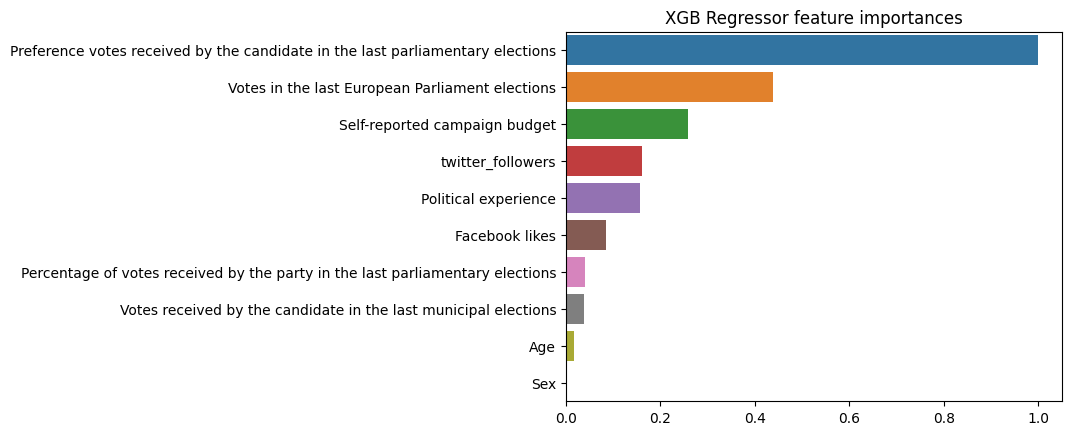

In [124]:
f_importance = xgb_reg.get_booster().get_score(importance_type='gain')

importance_df = pd.DataFrame.from_dict(data=f_importance, 
                                       orient='index')
importance_df.rename(columns={0: 'Importance'}, inplace=True)

scaler = MinMaxScaler() 
df_scaled = scaler.fit_transform(importance_df)
importance_df['Scaled'] = df_scaled
importance_df.sort_values('Scaled', ascending=False, inplace=True)

importance_df.rename(index={
    'prefvote' : 'Preference votes',
    'party_prefvote_lag': 'Percentage of votes received by the party in the last parliamentary elections',
    'prefvote_lag' : 'Preference votes received by the candidate in the last parliamentary elections',
    'age' : 'Age',
    'fb_likes' : 'Facebook likes',
    'last_presidential_elections' : 'Votes received by the candidate in the last presidential elections',
    'last_municipal_votes' : 'Votes received by the candidate in the last municipal elections',
    'last_eu_votes' : 'Votes in the last European Parliament elections',
    'dist_bkt_change' : 'The change of BKT of the electoral district last four years',
    'political_experience' : 'Political experience',
    'campaign_budget_scale' : 'Self-reported campaign budget',    
    'sex': 'Sex',
    'party_changed' : 'Changed party between the current and last parliamentary elections',
    'cabinet_last_parliament' : 'The party held cabinet in the last parliament'}, inplace=True)


fig, ax = plt.subplots()
sns.barplot(data=importance_df[['Scaled']].T, orient='h')
ax.set_title("XGB Regressor feature importances")
plt.show()


# D'hondt adjusted results

In [125]:
## D'hondt results

# xgb: test_xgb_result
# rf: test_continuous_result
predicted_results = test_xgb_result

d_hondt_result = pd.DataFrame()
all_candidates = pd.DataFrame()

for index, row in districts.iterrows():
    district = predicted_results.loc[predicted_results['district'] == row['distabb']]
    
    
    # calculate district total vote
    df_party_vote = district.groupby('party')['prediction'].sum().reset_index().rename(columns={'prediction': 'party_district_vote'})
    district = district.merge(df_party_vote, on='party', how='left')
    
    # d'hondt vote share calculus 
    district["placement"] = 1
    district = district.sort_values(by=['party', 'prediction'], ascending=False)
    district['placement_divisor'] =  district.groupby('party')['placement'].cumsum()

    district['propotional_votes'] = district['party_district_vote'] / district['placement_divisor']
    
    district_results = district.nlargest(row['seats'], 'propotional_votes')
    d_hondt_result = pd.concat([district_results, d_hondt_result])
    all_candidates = pd.concat([all_candidates, district])
    
#display(d_hondt_result.stb.freq(['prefvote']))
display(d_hondt_result.stb.freq(['party']))

,party,count,percent,cumulative_count,cumulative_percent
0,KOK,44,22.00,44,22.00
1,SDP,41,20.50,85,42.50
2,PS,40,20.00,125,62.50
3,KESK,25,12.50,150,75.00
4,VIHR,18,9.00,168,84.00
5,VAS,15,7.50,183,91.50
6,RKP,9,4.50,192,96.00
7,KD,5,2.50,197,98.50
8,LIIK,2,1.00,199,99.50
9,FÅ,1,0.50,200,100.00


In [126]:
display(all_candidates.stb.freq(['party'], value='prediction'))

,party,prediction,percent,cumulative_prediction,cumulative_percent
0,KOK,636846.75,19.13,636846.75,19.13
1,PS,571239.50,17.16,1208086.25,36.28
2,SDP,569123.62,17.09,1777209.88,53.38
3,KESK,377749.62,11.35,2154959.50,64.72
4,VIHR,352560.53,10.59,2507520.00,75.31
5,VAS,281731.00,8.46,2789251.00,83.77
6,RKP,163157.88,4.90,2952409.00,88.67
7,KD,116729.80,3.51,3069138.75,92.18
8,LIIK,91357.12,2.74,3160496.00,94.92
9,VL,44160.13,1.33,3204656.25,96.25


In [127]:
d_hondt_result.sort_values(by='prediction', ascending=False)

,candidate,prefvote,party_prefvote_lag,prefvote_lag,age,sex,fb_likes,last_presidential_elections,last_municipal_votes,last_eu_votes,political_experience,campaign_budget_scale,district,party,twitter_followers,prediction,party_district_vote,placement,placement_divisor,propotional_votes
0,Huhtasaari Laura,8393,24.10,12991,44,1,4800,207337,0,92760,5,0,SAT,PS,40920,15793.76,35732.11,1,1,35732.11
0,Essayah Sari,15862,7.85,12397,56,1,16034,0,236,53705,6,5,SKA,KD,21011,15727.88,24704.56,1,1,24704.56
2,Tavio Ville,15071,19.14,14957,38,0,6534,0,3880,0,5,4,VAR,PS,25562,15486.24,56829.29,1,1,56829.29
0,Marin Sanna,35628,22.10,19088,37,1,210908,0,10541,0,4,5,PIR,SDP,653126,15295.85,69812.95,1,1,69812.95
7,Haavisto Pekka,8036,23.51,20163,65,0,33347,371254,0,0,3,1,HEL,VIHR,201679,15281.21,121437.02,1,1,121437.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,Väyrynen Ville,7169,12.77,1980,47,0,951,0,367,0,2,4,KES,KOK,388,2543.54,20266.08,1,2,10133.04
105,Kondie Tuomo,197,9.64,0,29,0,302,0,0,0,0,3,SKA,VIHR,9084,2373.51,20640.63,1,2,10320.31
22,Hyvönen Saija,3607,20.39,2706,51,1,0,0,613,0,2,0,OUL,PS,0,2300.52,53790.52,1,5,10758.10
31,Kyllönen Tiina,2399,10.27,1810,39,1,533,0,218,0,3,3,OUL,SDP,0,2043.31,22849.99,1,2,11424.99


# Combination of the ex ante forecast with actual outcome of the elections

This is additional information that was added after the elections took place, as the candidates dataframe was expanded to include the outcome of the elections. The output of this cell is shared.

In [128]:
# Set unique identifier within the forecast data
all_candidates['unique_id'] = all_candidates['candidate'] + '_' + all_candidates['party'] + '_' + all_candidates['district'].astype(str)
d_hondt_result['unique_id'] = d_hondt_result['candidate'] + '_' + d_hondt_result['party'] + '_' + d_hondt_result['district'].astype(str)

# Use this reliable ID to flag the predicted winners
all_candidates['predicted_elected'] = 0
winners_ids = set(d_hondt_result['unique_id'])
all_candidates.loc[all_candidates['unique_id'].isin(winners_ids), 'predicted_elected'] = 1

# Verification
print(f"Verified count of predicted winners: {all_candidates['predicted_elected'].sum()}") # Should be 200
print("-" * 30)


# ---  MERGE ---

# Define the key for merging
robust_merge_key = ['candidate', 'age', 'sex', 'party', 'district']

# Create the new 'ex_post_result' DataFrame
ex_post_result = pd.merge(
    all_candidates,
    # Select the key columns + the result column from the source data
    candidates[robust_merge_key + ['election_result']],
    on=robust_merge_key,
    how='left'
)

# Verification
print(f"Verified count of actual winners in merged table: {(ex_post_result['election_result'] == 'ELECTED').sum()}")
print("-" * 30)

# --- ANALYSIS ---

print("\n--- Final Model Performance Analysis (on corrected data) ---")

# Define conditions
predicted_elected = (ex_post_result['predicted_elected'] == 1)
predicted_not_elected = (ex_post_result['predicted_elected'] == 0)
actually_elected = (ex_post_result['election_result'] == 'ELECTED')
actually_not_elected = (ex_post_result['election_result'] != 'ELECTED')

# Calculate the four categories
true_positives = (predicted_elected & actually_elected).sum()
false_positives = (predicted_elected & actually_not_elected).sum()
false_negatives = (predicted_not_elected & actually_elected).sum()
true_negatives = (predicted_not_elected & actually_not_elected).sum()

# Print the confusion matrix
print(f"Correctly Predicted Winners (True Positives):    {true_positives}")
print(f"Incorrectly Predicted Winners (False Positives):  {false_positives}")
print(f"Missed Winners (False Negatives):                 {false_negatives}")
print(f"Correctly Predicted Non-Winners (True Negatives): {true_negatives}")
print("-" * 30)

# Calculate and print key metrics
precision = (true_positives / (true_positives + false_positives)) * 100
recall = (true_positives / (true_positives + false_negatives)) * 100

print(f"Precision: {precision:.2f}%  (Of the 200 candidates we predicted to win, {true_positives} actually won)")
print(f"Recall:    {recall:.2f}%  (Of the 200 actual winners, we correctly identified {true_positives})")

Verified count of predicted winners: 200
------------------------------
Verified count of actual winners in merged table: 200
------------------------------

--- Final Model Performance Analysis (on corrected data) ---
Correctly Predicted Winners (True Positives):    150
Incorrectly Predicted Winners (False Positives):  50
Missed Winners (False Negatives):                 50
Correctly Predicted Non-Winners (True Negatives): 2174
------------------------------
Precision: 75.00%  (Of the 200 candidates we predicted to win, 150 actually won)
Recall:    75.00%  (Of the 200 actual winners, we correctly identified 150)


# Original Ex-Ante Forecast (Published Prior to the Election)

The forecast data presented below is the exact result that was published publicly before the election took place. The predicted vote counts and seat allocations may differ from the results generated by re-running the code in this notebook.

This discrepancy arises because the original `random_state` (seed) used for the published model was not recorded. As the analysis has shown, the model's predictions are sensitive to this seed, and without the original value, the results will have some variation.

# Algoritmi ennakoi tiukkaa kamppailua vaalien ykköspaikasta

Tutkijat ovat keränneet aineistoa ehdokkaiden Facebook ja Twitter seuraajamääristä jo kolmien eduskuntavaalien ajan. Aineiston pohjalta tehty ennuste ennakoi tiukkaa kamppailua ykköspaikasta Kokoomuksen, Perussuomalaisten ja Sosiaalidemokraattien välillä.

Tietojärjestelmätieteen oppiaineessa väitöskirjaa tekevä Tapio Vepsäläinen tutkii sosiaalisessa mediassa kerättyjen seuraajamäärien yhteyttä vaalimenestykseen. Tutkimusta varten on kerätty aineisto vuosien 2015, 2019, ja nyt viimeisimpänä, 2023 eduskuntavaalien ehdokkaista. Tämän vuoden eduskuntavaalien alla Facebookista löytyi 1146 ehdokkaan julkisilta kampanjasivuilta n. 2 miljoonaa tykkäystä, ja Twitteristä 1146 ehdokkaan sivuilta n. 5 miljoonaa seuraajaa. Lisäksi ennusteessa hyödynnettiin muuta julkisesti saatavilla olevaa aineistoa, kuten ehdokkaiden historiallisia äänimääriä eri vaaleissa, ehdokkaiden taustatietoja, sekä poliittisia meriittejä. Aineiston perusteella on laadittu ehdokaskohtainen ennuste.

## Ennustetulokset

Ennusteen perusteella Kokoomus, SDP ja Perussuomalaiset muodostavat kolmen kärjen. Eniten ääniä keräisi Kokoomus 19,2% kannatuksella. Kokoomukselle irtoaa 41 paikkaa, Perussuomalaisille 40, ja SDP:lle 39. Neljännelle sijalle päätyy keskusta, joka menettää edellisiin vaaleihin nähden 4 paikkaa. Myös vihreät menettävät 2 paikkaa. Vasemmistoliitto saa yhden paikan lisää, kuten myös Liike Nyt ja RKP. Ainoastaan KD:n paikkamäärä pysyy samana.

| Puolue | Paikat | Kannatus prosentti |
|--------|--------|-------------------|
| KOK | 41 | 19,20 % |
| PS | 40 | 17,19 % |
| SDP | 39 | 17,22 % |
| KESK | 27 | 11,60 % |
| VIHR | 18 | 10,71 % |
| VAS | 17 | 8,51 % |
| RKP | 10 | 4,89 % |
| KD | 5 | 3,58 % |
| LIIK | 2 | 2,62 % |
| FÅ (Ahvenanmaan vaalipiiri) | 1 | 0,37 % |
| Muut | 0 | 4,11 % |

Tulokset ovat melko lähellä Ylen viimeisimpiä kannatusmittauksia ja mahtuvat annettuun virhemarginaaliin. Ennusteen perusteella ei ole siis odotettavissa suurempia yllätyksiä.

## Merkittävä ero aikaisempiin ennusteisiin

Aikaisemmat ennusteet (linkki 2015, linkki 2019) ovat pohjautuneet pelkästään Facebookissa kerättyihin seuraajamääriin. Uusin malli hyödyntää Twitteristä kerättyjen tietoja, sekä lisäksi muita taustatietoja. Ennusteessa korkean painoarvon on saanut etenkin aikaisempi vaalimenestys. Ehkä voisi sanoa, että malli ennustaa ehdokaslistojen laatua. Kuinka kokeneita ja menestyneitä ehdokkaita puolueilla on listoilla? Asetelma ei ota kovin tarkasti kantaa nykyiseen mielipide-ilmapiiriin, vaan antaa isomman painoarvon historialliselle menestykselle.

Ehdokkaiden sosiaalisen median käyttö on muuttunut selvästi aikaisempiin vaaleihin verrattuna. Perussuomalaiset ovat olleet aikaisemmissa ennusteisa selkeästi ali-edustettuina, mutta asettuisivat nyt 2. sijalle. Tämä näkyy myös pelkästään sosiaaliseen mediaan pohjautuvassa arviossa. Kokoomus on yhä vahvin sosiaalisessa mediassa tykkäys- ja seuraajamäärien perusteella, mutta Perussuomalaiset ja SDP ovat kiilanneet vihreiden ohi.

## Miten ennuste on laadittu?

Malli pohjautuu verkossa julkisesti saatavilla olevaan aineistoon. Ennustavia muuttujia ovat ehdokkaiden seuraajamäärät Facebookissa ja Twitterissä, ehdokkaiden ja puolueiden aikaisempi vaalimenestys, muut ehdokkaiden julkisesti saatavilla olevat taustatiedot, sekä heidän arvioitu poliittinen kokemus. Malli on toteutettu avoimeen lähdekoodiin pohjautuvalla XGBoost (eXtreme Gradient Boosting) koneoppimis algoritmilla ([https://github.com/dmlc/xgboost](https://github.com/dmlc/xgboost)). Hyperparametrien optimointiin on käytetty Optunaa ([https://github.com/optuna/optuna](https://github.com/optuna/optuna)), joka on myös avoimen lähdekoodin ohjelmisto.

Malli ennustaa kunkin ehdokkaan tietoihin perustuen ehdokas kohtaisen äänimäärän. Lopuksi ehdokkaiden vertausluvut ja läpimeno on laskettu D'Hondtin menetelmän mukaisesti.

Nykyisen mallin kehittämisen mahdollisti aikaisemmissa vaaleissa kerätty aineisto. Koneoppimismalli on opetettu eduskuntavaaleista 2015 ja 2019 kerätyllä uniikilla aineistolla. Hyödynnetty algoritmi ei ole uusi, mutta sen hyödyntäminen vaalien kontekstissa on ollut aikaisemmin haastavaa riittävän datan puuttuessa.

## Aineiston keräys

Aineistoa on kerätty vuosien varrella eri menetelmillä. Sosiaalisen median palvelut muuttuvat jatkuvasti. Facebook sulki rajapintansa tutkijoilta 2018, ja Twitter rajoitti merkittävästi tiedon saatavuutta helmikuussa 2023 ([https://techcrunch.com/2023/02/01/twitter-to-end-free-access-to-its-api/](https://techcrunch.com/2023/02/01/twitter-to-end-free-access-to-its-api/)). Facebook ja Twitter sivut ovat kuitenkin julkisesti saatavilla, joten aineistoa voi yhä kerätä. Vuoden 2023 aineiston keräys eroaa sikäli aikaisemmista vaaleista, että tällä kertaa suurin osa tiedoista on haettu hakukoneiden kautta.

## Vastaavien ennusteiden tulevaisuus

Facebookin suosio näyttää hieman hiipuneen ehdokkaiden keskuudessa. Puhetta käyttäjien siirtymisestä muille alustoille on ollut pitkään. Twitterin omistajapohjan muutokset ovat myös omalta osaltaan johtaneet spekulaatioon alustan tulevaisuudesta. Erilaiset sosiaalisen median palvelut tulevat varmasti olemaan jatkossa ajankohtaisia, mutta on vaikea sanoa mitkä kanavat tulevat olemaan tärkeimpiä. Tulevaisuudessa olisi kenties viisainta etsiä se kanava, jossa ehdokkaalla on eniten seuraajia, oli se sitten Facebook, Twitter tai Instagram, ja hyödyntää sitä mittarina.

Uudet innovaatiot tekoälyn saralla saattavat helpottaa aineiston keräämistä tulevaisuudessa. Tällä hetkellä aineiston keräämiseen liittyy vielä jonkin verran haasteita, etenkin tietojen oikeellisuuden tarkistuksessa. Tulevaisuudessa esimerkiksi internettiin kytketyt GPT-3 tyyppiset LLM mallit voisivat helpottaa materiaalien keräämistä. Tästä esimerkkinä Bingin haku botti, jonka ainakin teoriassa pitäisi olla tehokas työkalu seuraajamäärien keräämiseen. LLM mallit voisivat myös helpottaa muun mediasisällön keräämistä. Aiheella on hieman aikaista spekuloida, mutta odotan innolla miten käy.
